# Modificações

1. Testar como a RN se porta com o Data Augmentation em uma escala menor e em uma escala maior do que a melhor métrica feita 
    - Menor tamanho do DA: 10
    - Maior tamanho do DA: 50

* O armazenamento da melhor tentativa com base em uma métrica de prioridade ainda está sendo a AUC como critério principal

Tentativa 1: accuracy=0.647, recall_1=0.375, recall_0=0.889, AUC=0.847
Tentativa 2: accuracy=0.529, recall_1=0.125, recall_0=0.889, AUC=0.750
Tentativa 3: accuracy=0.647, recall_1=0.375, recall_0=0.889, AUC=0.889
Tentativa 4: accuracy=0.706, recall_1=0.375, recall_0=1.000, AUC=0.778
Tentativa 5: accuracy=0.471, recall_1=0.375, recall_0=0.556, AUC=0.681
Tentativa 6: accuracy=0.647, recall_1=0.500, recall_0=0.778, AUC=0.861
Tentativa 7: accuracy=0.882, recall_1=0.875, recall_0=0.889, AUC=0.903

Critérios atendidos! Parando o treinamento.

=== RELATÓRIO DE CLASSIFICAÇÃO FINAL ===
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17



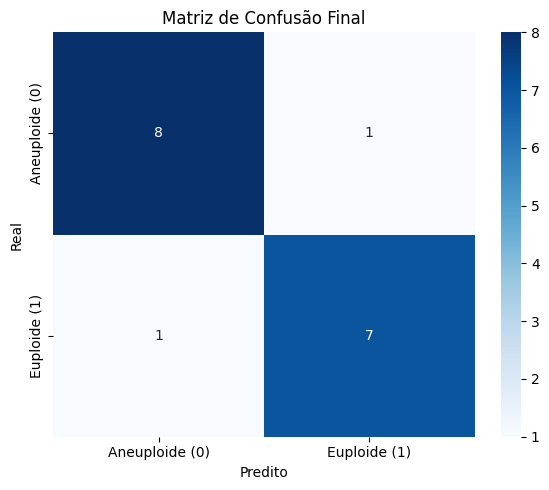

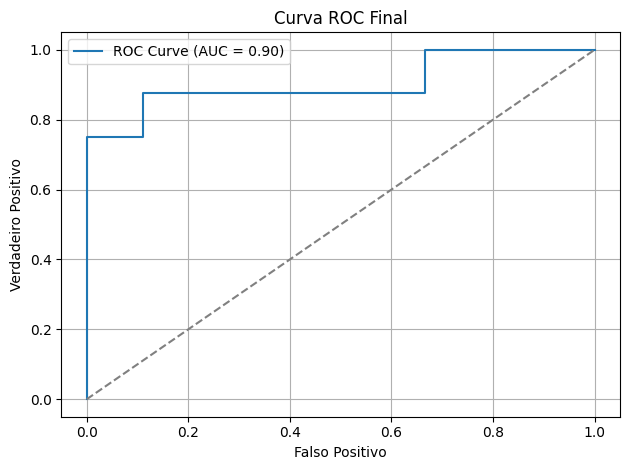

In [ ]:
## MENOR CASO DO 1º DA - 10

import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURAÇÃO DE AVISOS ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === CARREGAR DADOS ORIGINAIS ===
df_original = pd.read_excel(r"PlanilhaNumerica.xlsx")

# === DIVISÃO EM TREINAMENTO E TESTE ===
X_full = df_original.drop(columns=["Ploidia"])
y_full = df_original["Ploidia"]
X_train_base, X_test, y_train_base, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

df_train = pd.concat([X_train_base, y_train_base], axis=1)

# === AUMENTO DE DADOS ===
col_alvo = "Ploidia"
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns.drop(col_alvo)
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist() + [col_alvo]

augmentation_factor = 10
num_new_samples = len(df_train) * augmentation_factor
new_samples = {}

for col in numerical_columns:
    mean = df_train[col].mean()
    std = df_train[col].std()
    generated = np.random.normal(loc=mean, scale=std, size=num_new_samples)
    new_samples[col] = np.clip(generated, df_train[col].min(), df_train[col].max())

df_new_samples = pd.DataFrame(new_samples)
for col in categorical_columns:
    df_new_samples[col] = np.random.choice(df_train[col], size=num_new_samples, replace=True)

df_augmented = pd.concat([df_train, df_new_samples], ignore_index=True)

# === TREINAMENTO COM PARÂMETROS DE PARADA ===
melhor_modelo = None
melhores_metricas = {"accuracy": 0, "recall_1": 0, "recall_0": 0, "auc": 0}
X = df_augmented.drop(columns=["Ploidia"])
y = df_augmented["Ploidia"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

criterios = {
    "accuracy": 0.80,
    "recall_1": 0.75,
    "recall_0": 0.75,
    "auc": 0.85
}

for attempt in range(1, 51):
    modelo = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, activation='relu', solver='adam', random_state=attempt)
    modelo.fit(X_scaled, y)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Tentativa {attempt}: accuracy={acc:.3f}, recall_1={recall_1:.3f}, recall_0={recall_0:.3f}, AUC={auc:.3f}")

    if (
        acc >= criterios["accuracy"] and
        recall_1 >= criterios["recall_1"] and
        recall_0 >= criterios["recall_0"] and
        auc >= criterios["auc"]
    ):
        melhor_modelo = modelo
        melhores_metricas = {"accuracy": acc, "recall_1": recall_1, "recall_0": recall_0, "auc": auc}
        print("\nCritérios atendidos! Parando o treinamento.")
        break

    if auc > melhores_metricas["auc"]:
        melhor_modelo = modelo
        melhores_metricas = {"accuracy": acc, "recall_1": recall_1, "recall_0": recall_0, "auc": auc}

# === RELATÓRIO FINAL ===
y_pred = melhor_modelo.predict(X_test_scaled)
y_proba = melhor_modelo.predict_proba(X_test_scaled)[:, 1]

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO FINAL ===")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão Final")
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC Final")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Resumo dos Resultados Finais Menor DA - MELHOR RESULTADO

## Acurácia geral
- **Acurácia**: 88% → O modelo acertou 15 das 17 previsões.

## Relatório de Classificação
| Classe         | Precisão (Precision) | Revocação (Recall) | F1-score | Amostras (Support) |
|----------------|----------------------|---------------------|----------|---------------------|
| Aneuploide (0) | 0.89                 | 0.89                | 0.89     | 9                   |
| Euploide (1)   | 0.88                 | 0.88                | 0.88     | 8                   |
| Média macro    | 0.88                 | 0.88                | 0.88     | 17                  |
- **Precision**: Proporção de verdadeiros positivos entre todas as predições positivas.
- **Recall**: Proporção de verdadeiros positivos entre todos os exemplos realmente positivos.
- **F1-score**: Harmônica entre precisão e recall → bom resumo geral.
- **Macro avg**: Média aritmética simples entre as classes, trata igualmente as classes (mesmo que desbalanceadas).

## Interpretação
- O modelo está muito equilibrado entre as classes.
- Desempenho praticamente idêntico para aneuploides e euploides, o que é raro e excelente em datasets biomédicos.

## Matriz de Confusão
| Real \ Predito | Aneuploide (0) | Euploide (1) |
|----------------|----------------|---------------|
| Aneuploide (0) | 8              | 1             |
| Euploide (1)   | 1              | 7             |
- Erros:
    - 1 euploide classificado como aneuploide
    - 1 aneuploide classificado como euploide
        - Os dois tipos de erro estão balanceados e mínimos.

## Curva ROC e AUC
- **AUC** = 0.90 → Excelente capacidade de separação entre classes.
- **Curva ROC longe da diagonal** → o modelo é muito superior ao acaso.
- O modelo responde bem mesmo com diferentes thresholds (limiares).

Tentativa 1: accuracy=0.529, recall_1=0.500, recall_0=0.556, AUC=0.542
Tentativa 2: accuracy=0.588, recall_1=0.750, recall_0=0.444, AUC=0.639
Tentativa 3: accuracy=0.647, recall_1=0.625, recall_0=0.667, AUC=0.722
Tentativa 4: accuracy=0.706, recall_1=0.625, recall_0=0.778, AUC=0.639
Tentativa 5: accuracy=0.588, recall_1=0.500, recall_0=0.667, AUC=0.569
Tentativa 6: accuracy=0.471, recall_1=0.625, recall_0=0.333, AUC=0.611
Tentativa 7: accuracy=0.529, recall_1=0.500, recall_0=0.556, AUC=0.528
Tentativa 8: accuracy=0.353, recall_1=0.125, recall_0=0.556, AUC=0.347
Tentativa 9: accuracy=0.412, recall_1=0.625, recall_0=0.222, AUC=0.486
Tentativa 10: accuracy=0.471, recall_1=0.375, recall_0=0.556, AUC=0.444
Tentativa 11: accuracy=0.647, recall_1=0.625, recall_0=0.667, AUC=0.681
Tentativa 12: accuracy=0.529, recall_1=0.375, recall_0=0.667, AUC=0.514
Tentativa 13: accuracy=0.529, recall_1=0.625, recall_0=0.444, AUC=0.417
Tentativa 14: accuracy=0.647, recall_1=0.500, recall_0=0.778, AUC=0.681
T

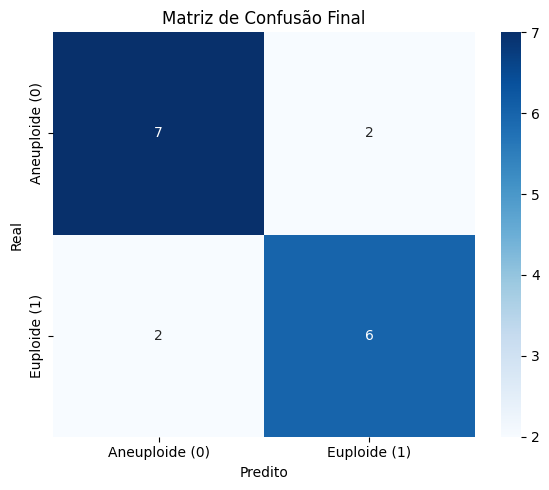

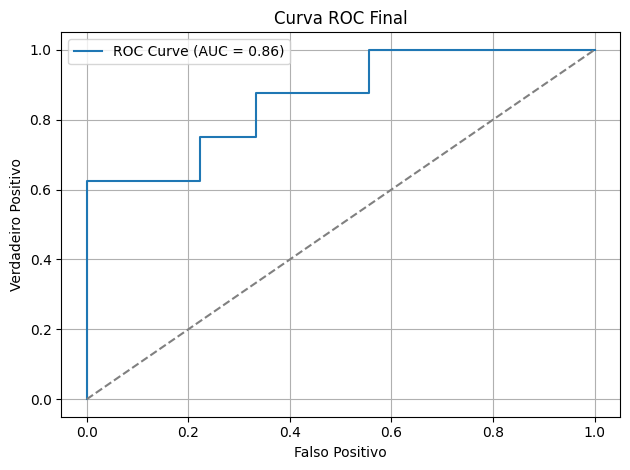

In [2]:
## MAIOR CASO DO DA

import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURAÇÃO DE AVISOS ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === CARREGAR DADOS ORIGINAIS ===
df_original = pd.read_excel(r"PlanilhaNumerica.xlsx")

# === DIVISÃO EM TREINAMENTO E TESTE ===
X_full = df_original.drop(columns=["Ploidia"])
y_full = df_original["Ploidia"]
X_train_base, X_test, y_train_base, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

df_train = pd.concat([X_train_base, y_train_base], axis=1)

# === AUMENTO DE DADOS ===
col_alvo = "Ploidia"
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns.drop(col_alvo)
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist() + [col_alvo]

augmentation_factor = 50
num_new_samples = len(df_train) * augmentation_factor
new_samples = {}

for col in numerical_columns:
    mean = df_train[col].mean()
    std = df_train[col].std()
    generated = np.random.normal(loc=mean, scale=std, size=num_new_samples)
    new_samples[col] = np.clip(generated, df_train[col].min(), df_train[col].max())

df_new_samples = pd.DataFrame(new_samples)
for col in categorical_columns:
    df_new_samples[col] = np.random.choice(df_train[col], size=num_new_samples, replace=True)

df_augmented = pd.concat([df_train, df_new_samples], ignore_index=True)

# === TREINAMENTO COM PARÂMETROS DE PARADA ===
melhor_modelo = None
melhores_metricas = {"accuracy": 0, "recall_1": 0, "recall_0": 0, "auc": 0}
X = df_augmented.drop(columns=["Ploidia"])
y = df_augmented["Ploidia"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

criterios = {
    "accuracy": 0.80,
    "recall_1": 0.75,
    "recall_0": 0.75,
    "auc": 0.85
}

for attempt in range(1, 51):
    modelo = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, activation='relu', solver='adam', random_state=attempt)
    modelo.fit(X_scaled, y)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Tentativa {attempt}: accuracy={acc:.3f}, recall_1={recall_1:.3f}, recall_0={recall_0:.3f}, AUC={auc:.3f}")

    if (
        acc >= criterios["accuracy"] and
        recall_1 >= criterios["recall_1"] and
        recall_0 >= criterios["recall_0"] and
        auc >= criterios["auc"]
    ):
        melhor_modelo = modelo
        melhores_metricas = {"accuracy": acc, "recall_1": recall_1, "recall_0": recall_0, "auc": auc}
        print("\nCritérios atendidos! Parando o treinamento.")
        break

    if auc > melhores_metricas["auc"]:
        melhor_modelo = modelo
        melhores_metricas = {"accuracy": acc, "recall_1": recall_1, "recall_0": recall_0, "auc": auc}

# === RELATÓRIO FINAL ===
y_pred = melhor_modelo.predict(X_test_scaled)
y_proba = melhor_modelo.predict_proba(X_test_scaled)[:, 1]

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO FINAL ===")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão Final")
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC Final")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Resumo dos Resultados Finais maior DA - MELHOR RESULTADO

Foi um resultado inferior e demorou mais tempo, ou seja, percebemos que quanto maior um data augmentation, menor a chance de se conseguir chegar nas métricas impostas.

Tentativa 1: accuracy=0.480, recall_1=0.500, recall_0=0.455, AUC=0.409
Tentativa 2: accuracy=0.480, recall_1=0.571, recall_0=0.364, AUC=0.552
Tentativa 3: accuracy=0.520, recall_1=0.643, recall_0=0.364, AUC=0.526
Tentativa 4: accuracy=0.440, recall_1=0.429, recall_0=0.455, AUC=0.513
Tentativa 5: accuracy=0.480, recall_1=0.500, recall_0=0.455, AUC=0.487
Tentativa 6: accuracy=0.400, recall_1=0.357, recall_0=0.455, AUC=0.468
Tentativa 7: accuracy=0.440, recall_1=0.429, recall_0=0.455, AUC=0.474
Tentativa 8: accuracy=0.400, recall_1=0.500, recall_0=0.273, AUC=0.455
Tentativa 9: accuracy=0.320, recall_1=0.429, recall_0=0.182, AUC=0.442
Tentativa 10: accuracy=0.400, recall_1=0.429, recall_0=0.364, AUC=0.370
Tentativa 11: accuracy=0.480, recall_1=0.500, recall_0=0.455, AUC=0.500
Tentativa 12: accuracy=0.400, recall_1=0.429, recall_0=0.364, AUC=0.396
Tentativa 13: accuracy=0.440, recall_1=0.500, recall_0=0.364, AUC=0.455
Tentativa 14: accuracy=0.480, recall_1=0.571, recall_0=0.364, AUC=0.461
T

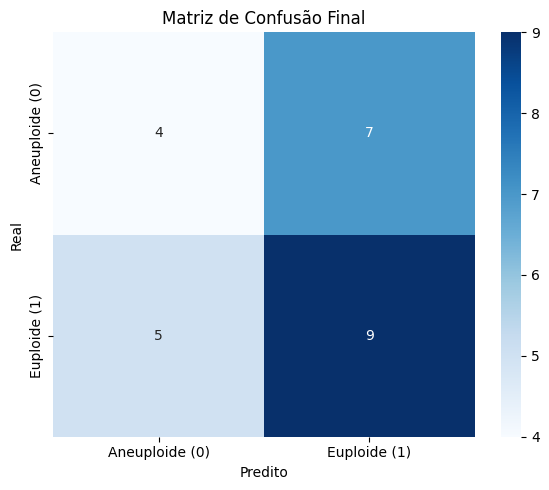

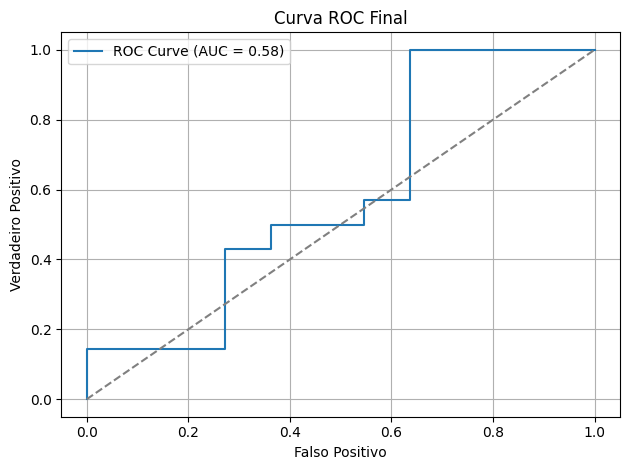

Modelo salvo como: melhor_modelo_mlp_20250618_093851.pkl
Scaler salvo como: scaler_mlp_20250618_093851.pkl


In [3]:
## MENOR CASO DO 1º DA - 10

import pandas as pd
import numpy as np
import joblib
import warnings
import datetime
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURAÇÃO DE AVISOS ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === CARREGAR DADOS ORIGINAIS ===
df_original = pd.read_excel(r"PlanilhaNumericaUnificada.xlsx")

# === DIVISÃO EM TREINAMENTO E TESTE ===
X_full = df_original.drop(columns=["Ploidia"])
y_full = df_original["Ploidia"]
X_train_base, X_test, y_train_base, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

df_train = pd.concat([X_train_base, y_train_base], axis=1)

# === AUMENTO DE DADOS ===
col_alvo = "Ploidia"
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns.drop(col_alvo)
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist() + [col_alvo]

augmentation_factor = 2
num_new_samples = len(df_train) * augmentation_factor
new_samples = {}

for col in numerical_columns:
    mean = df_train[col].mean()
    std = df_train[col].std()
    generated = np.random.normal(loc=mean, scale=std, size=num_new_samples)
    new_samples[col] = np.clip(generated, df_train[col].min(), df_train[col].max())

df_new_samples = pd.DataFrame(new_samples)
for col in categorical_columns:
    df_new_samples[col] = np.random.choice(df_train[col], size=num_new_samples, replace=True)

df_augmented = pd.concat([df_train, df_new_samples], ignore_index=True)

# === TREINAMENTO COM PARÂMETROS DE PARADA ===
melhor_modelo = None
melhores_metricas = {"accuracy": 0, "recall_1": 0, "recall_0": 0, "auc": 0}
X = df_augmented.drop(columns=["Ploidia"])
y = df_augmented["Ploidia"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

criterios = {
    "accuracy": 0.90,
    "recall_1": 0.85,
    "recall_0": 0.85,
    "auc": 0.98
}

for attempt in range(1, 51):
    modelo = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, activation='relu', solver='adam', random_state=attempt)
    modelo.fit(X_scaled, y)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Tentativa {attempt}: accuracy={acc:.3f}, recall_1={recall_1:.3f}, recall_0={recall_0:.3f}, AUC={auc:.3f}")

    if (
        acc >= criterios["accuracy"] and
        recall_1 >= criterios["recall_1"] and
        recall_0 >= criterios["recall_0"] and
        auc >= criterios["auc"]
    ):
        melhor_modelo = modelo
        melhores_metricas = {"accuracy": acc, "recall_1": recall_1, "recall_0": recall_0, "auc": auc}
        print("\nCritérios atendidos! Parando o treinamento.")
        break

    if auc > melhores_metricas["auc"]:
        melhor_modelo = modelo
        melhores_metricas = {"accuracy": acc, "recall_1": recall_1, "recall_0": recall_0, "auc": auc}

# === RELATÓRIO FINAL ===
y_pred = melhor_modelo.predict(X_test_scaled)
y_proba = melhor_modelo.predict_proba(X_test_scaled)[:, 1]

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO FINAL ===")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão Final")
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC Final")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === GERAR NOME ÚNICO COM TIMESTAMP ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
modelo_filename = f"melhor_modelo_mlp_{timestamp}.pkl"
scaler_filename = f"scaler_mlp_{timestamp}.pkl"

# === SALVAR MODELO E SCALER ===
joblib.dump(melhor_modelo, modelo_filename)
joblib.dump(scaler, scaler_filename)

print(f"Modelo salvo como: {modelo_filename}")
print(f"Scaler salvo como: {scaler_filename}")

In [5]:
# TESTAR PKL (Saber qual é qual)

import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score

# === CARREGAR OS DADOS ===
df_original = pd.read_excel("PlanilhaNumerica.xlsx")
X = df_original.drop(columns=["Ploidia"])
y = df_original["Ploidia"]

# Mesmo split usado no treinamento
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === CARREGAR MODELO E SCALER SALVOS ===
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl") 

# === APLICAR O SCALER NOS DADOS DE TESTE ===
X_test_scaled = scaler.transform(X_test)

# === FAZER PREVISÕES ===
y_pred = modelo.predict(X_test_scaled)
y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

# === CALCULAR MÉTRICAS ===
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
auc = roc_auc_score(y_test, y_proba)

# === EXIBIR RESULTADOS ===
print(f"Acurácia (accuracy): {accuracy:.3f}")
print(f"Recall para Euploide (recall_1): {recall_1:.3f}")
print(f"Recall para Aneuploide (recall_0): {recall_0:.3f}")
print(f"AUC: {auc:.3f}")


Acurácia (accuracy): 0.882
Recall para Euploide (recall_1): 0.750
Recall para Aneuploide (recall_0): 1.000
AUC: 0.944


Acurácia (accuracy): 0.882
Recall para Euploide (recall_1): 0.750
Recall para Aneuploide (recall_0): 1.000
AUC: 0.944

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.75      0.86         8

    accuracy                           0.88        17
   macro avg       0.91      0.88      0.88        17
weighted avg       0.90      0.88      0.88        17



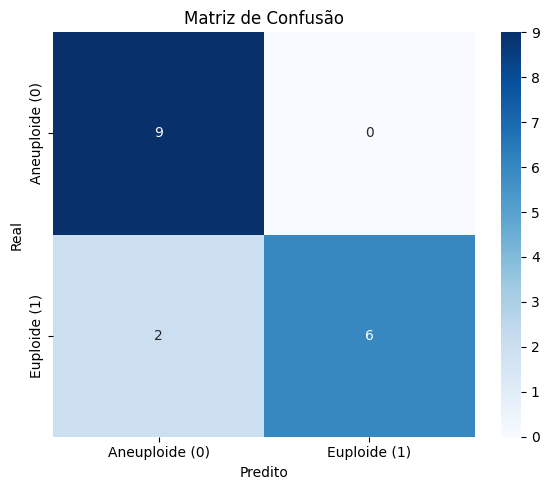

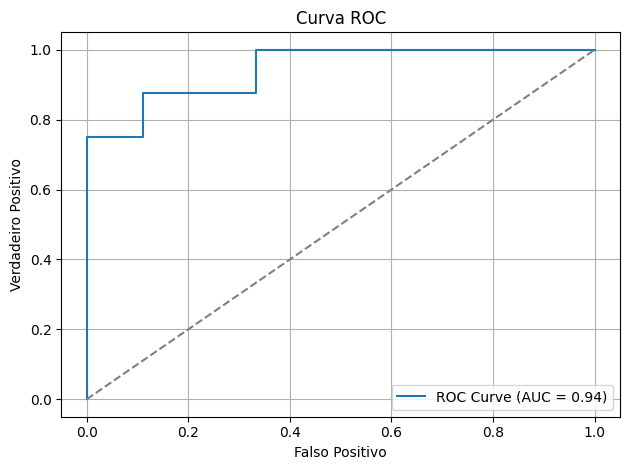

In [6]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split

# === CARREGAR OS DADOS ===
df_original = pd.read_excel("PlanilhaNumerica.xlsx")
X = df_original.drop(columns=["Ploidia"])
y = df_original["Ploidia"]

# Mesmo split usado no treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === CARREGAR MODELO E SCALER SALVOS ===
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# === APLICAR O SCALER NOS DADOS DE TESTE ===
X_test_scaled = scaler.transform(X_test)

# === FAZER PREVISÕES ===
y_pred = modelo.predict(X_test_scaled)
y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

# === CALCULAR MÉTRICAS ===
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
auc = roc_auc_score(y_test, y_proba)

# === EXIBIR RESULTADOS NUMÉRICOS ===
print(f"Acurácia (accuracy): {accuracy:.3f}")
print(f"Recall para Euploide (recall_1): {recall_1:.3f}")
print(f"Recall para Aneuploide (recall_0): {recall_0:.3f}")
print(f"AUC: {auc:.3f}")

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

# === MATRIZ DE CONFUSÃO COM GRÁFICO ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# === CURVA ROC COM GRÁFICO ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import sys
!{sys.executable} -m pip install imbalanced-learn


  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)

   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -

c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:47:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:47:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:47:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserW


🔍 AUC médio na validação cruzada: 0.697 (+/- 0.102)


c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:47:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.67      0.71      0.69        14

    accuracy                           0.68        28
   macro avg       0.68      0.68      0.68        28
weighted avg       0.68      0.68      0.68        28



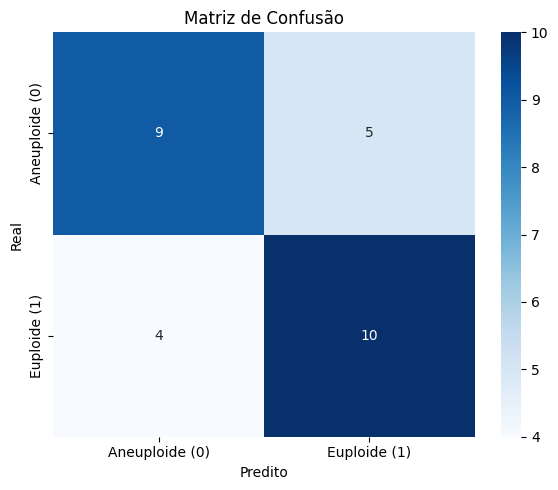

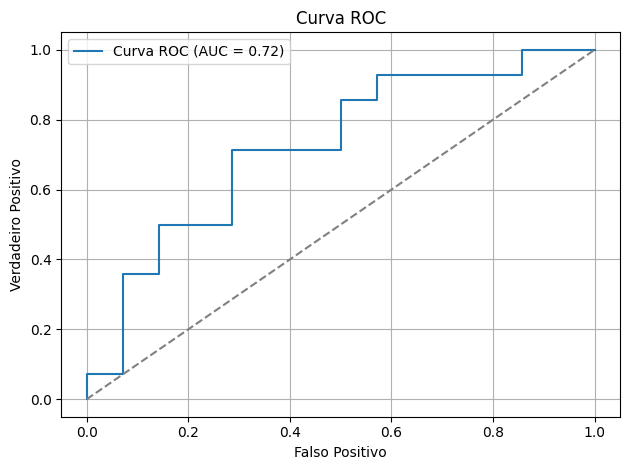


✅ Modelo salvo como: melhor_modelo_xgb_20250618_094754.pkl
✅ Scaler salvo como: scaler_xgb_20250618_094754.pkl


In [11]:
import pandas as pd
import numpy as np
import joblib
import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# === CARREGAR DADOS ===
df = pd.read_excel(r"PlanilhaNumericaUnificada.xlsx")

X = df.drop(columns=["Ploidia"])
y = df["Ploidia"]

# === ESCALONAMENTO ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === APLICAR SMOTE (Balanceamento) ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# === DEFINIR MODELO XGBoost ===
modelo = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# === VALIDAÇÃO CRUZADA ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(modelo, X_resampled, y_resampled, cv=kf, scoring='roc_auc')

print(f"\n🔍 AUC médio na validação cruzada: {scores.mean():.3f} (+/- {scores.std():.3f})")

# === AJUSTE FINAL COM SPLIT PARA RELATÓRIO ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

# === RELATÓRIO DE CLASSIFICAÇÃO ===
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

# === MATRIZ DE CONFUSÃO ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# === CURVA ROC ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === SALVAR MODELO E SCALER ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
modelo_filename = f"melhor_modelo_xgb_{timestamp}.pkl"
scaler_filename = f"scaler_xgb_{timestamp}.pkl"

joblib.dump(modelo, modelo_filename)
joblib.dump(scaler, scaler_filename)

print(f"\n✅ Modelo salvo como: {modelo_filename}")
print(f"✅ Scaler salvo como: {scaler_filename}")